# Wnioski z poprzedniego zadania


Warto rozważyć usunięcie kolumny Cabin, gdyż ma ona bardzo dużo brakujących wartości. Stworzenie kolumn IsAlone i IsChild było dobrym pomysłem, natomiast usunięcie kolumny Fare było złe.

# Wczytanie i szybka obróbka danych danych

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [130]:
titanic_df = pd.read_csv('/content/drive/MyDrive/ML_kurs/Data/titanic.csv')

In [131]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 1, 'female': 0})

In [132]:
def column_distribution(df, column):
  return df[column].value_counts(normalize=True)

In [133]:
age_count_prob = column_distribution(titanic_df, 'Age')
age_count_prob
fare_count_prob = column_distribution(titanic_df, 'Fare')

In [134]:
age_values = age_count_prob.index
age_probs = age_count_prob.values

fare_values = fare_count_prob.index
fare_probs = fare_count_prob.values

In [135]:
missing_age = titanic_df.Age.isna()
titanic_df.loc[missing_age, 'Age'] = np.random.choice(age_values, size=missing_age.sum(), p=age_probs)

missing_fare = titanic_df.Fare.isna()
titanic_df.loc[missing_fare, 'Fare'] = np.random.choice(fare_values, size=missing_fare.sum(), p=fare_probs)

In [136]:
titanic_df.Age.isna().sum()
titanic_df.Fare.isna().sum()

np.int64(0)

In [137]:
titanic_df['IsChild'] = (titanic_df['Age'] < 16).astype(int)
titanic_df['IsAlone'] = ((titanic_df['IsChild'] == 0) & ((titanic_df['SibSp'] + titanic_df['Parch']) == 0)).astype(int)

In [138]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsChild,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,30.0,1,2,W./C. 6607,23.4500,NaN,S,0,0
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C,0,1


# Podział zbioru danych

In [139]:
X = titanic_df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId', 'Survived'], axis=1)
y = titanic_df['Survived']
print(X)
print(y)

     Pclass  Sex   Age  SibSp  Parch     Fare  IsChild  IsAlone
0         3    1  22.0      1      0   7.2500        0        0
1         1    0  38.0      1      0  71.2833        0        0
2         3    0  26.0      0      0   7.9250        0        1
3         1    0  35.0      1      0  53.1000        0        0
4         3    1  35.0      0      0   8.0500        0        1
..      ...  ...   ...    ...    ...      ...      ...      ...
886       2    1  27.0      0      0  13.0000        0        1
887       1    0  19.0      0      0  30.0000        0        1
888       3    0  30.0      1      2  23.4500        0        0
889       1    1  26.0      0      0  30.0000        0        1
890       3    1  32.0      0      0   7.7500        0        1

[891 rows x 8 columns]
0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


Weryfikacja jak wyglądają dane i target

In [140]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pclass   891 non-null    int64  
 1   Sex      891 non-null    int64  
 2   Age      891 non-null    float64
 3   SibSp    891 non-null    int64  
 4   Parch    891 non-null    int64  
 5   Fare     891 non-null    float64
 6   IsChild  891 non-null    int64  
 7   IsAlone  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


Sprawdzenie czy na pewno nie ma brakujących wartości

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True)

Podział danych na zbiór treningowy i testowy gdzie 80% danych będzie w zbiorze treningowym a 20% w zbiorze testowym

In [142]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

Zdefiniowanie oraz wyuczenie modelu

In [143]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       104
           1       0.85      0.73      0.79        75

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Predykcja wartości waraz z wyświetleniem podstawowych metryk aby zobaczyć jak model sobie radzi z klasyfikacją


In [144]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [145]:
y_pred_dummy = dummy_model.predict(X_test)
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       104
           1       0.36      0.40      0.38        75

    accuracy                           0.45       179
   macro avg       0.45      0.45      0.44       179
weighted avg       0.46      0.45      0.46       179



Porównanie z DummyClassifier

# Porównanie dwóch wybranych modeli




In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [147]:
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Zdefiniowanie dwóch modeli, drzewa decyzyjnego oraz k-najbliższych sąsiadów

In [148]:
tree_pred = tree_model.predict(X_test)
knn_pred = knn.predict(X_test)

Predykcja

In [149]:
print('Decision tree classification report')
print(classification_report(y_test, tree_pred))
print('KNN classification report')
print(classification_report(y_test, knn_pred))

Decision tree classification report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       104
           1       0.83      0.67      0.74        75

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179

KNN classification report
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       104
           1       0.67      0.59      0.62        75

    accuracy                           0.70       179
   macro avg       0.70      0.69      0.69       179
weighted avg       0.70      0.70      0.70       179



In [150]:
print('ROC score for Decision tree: ', roc_auc_score(y_test, tree_pred))
print('ROC score for KNN: ', roc_auc_score(y_test, knn_pred))

ROC score for Decision tree:  0.7852564102564102
ROC score for KNN:  0.6875641025641026


Wypisanie metryk za pomocą classification report oraz roc auc score. Classification report jest wygodną metodą, ponieważ zawiera podstawowe metryki w jednym miejscu i wyświetla je za jednym razem. Roc auc score daje nam pole pod krzywą ROC, im większa jest ta wartość tym model lepiej klasyfikuje.

# Badanie dwóch modeli


In [151]:
tree_model = DecisionTreeClassifier(max_depth=5, splitter='best')
tree_model.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Ustawienie klasyfikatorów dla drzewa decyzyjnego splitter - best, max_depth=5, natomiast dla
KNN - n_neighbors=3, weights - uniform

In [152]:
tree_pred = tree_model.predict(X_test)
knn_pred = knn.predict(X_test)

In [153]:
print('Decision tree classification report')
print(classification_report(y_test, tree_pred))
print('KNN classification report')
print(classification_report(y_test, knn_pred))

Decision tree classification report
              precision    recall  f1-score   support

           0       0.72      0.96      0.83       104
           1       0.90      0.49      0.64        75

    accuracy                           0.77       179
   macro avg       0.81      0.73      0.73       179
weighted avg       0.80      0.77      0.75       179

KNN classification report
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       104
           1       0.64      0.60      0.62        75

    accuracy                           0.69       179
   macro avg       0.68      0.68      0.68       179
weighted avg       0.69      0.69      0.69       179



In [154]:
print('ROC score for Decision tree: ', roc_auc_score(y_test, tree_pred))
print('ROC score for KNN: ', roc_auc_score(y_test, knn_pred))

ROC score for Decision tree:  0.7274358974358974
ROC score for KNN:  0.6798076923076923


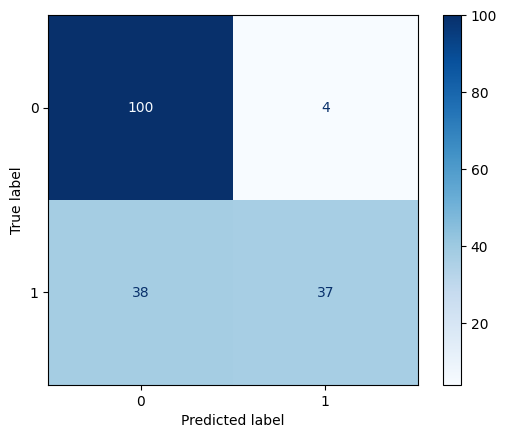

In [155]:
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test, cmap="Blues")

Macierz pomyłek dla drzewa decyzyjnego


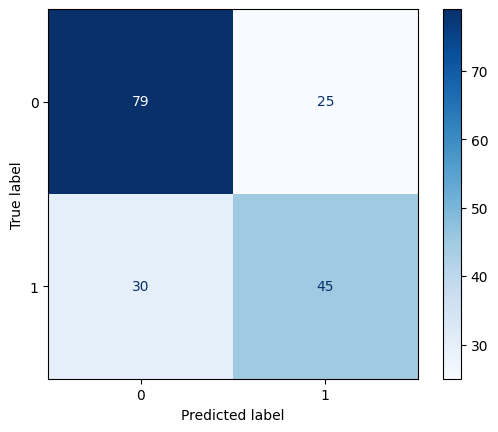

In [156]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues")

Macierz pomyłek dla KNN

In [157]:
tree_model = DecisionTreeClassifier(max_depth=10, splitter='random')
tree_model.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

Ustawienie innych parametrów

In [158]:
tree_pred = tree_model.predict(X_test)
knn_pred = knn.predict(X_test)

In [159]:
print('Decision tree classification report')
print(classification_report(y_test, tree_pred))
print('KNN classification report')
print(classification_report(y_test, knn_pred))

Decision tree classification report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       104
           1       0.80      0.68      0.73        75

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

KNN classification report
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       104
           1       0.65      0.59      0.62        75

    accuracy                           0.69       179
   macro avg       0.68      0.68      0.68       179
weighted avg       0.69      0.69      0.69       179



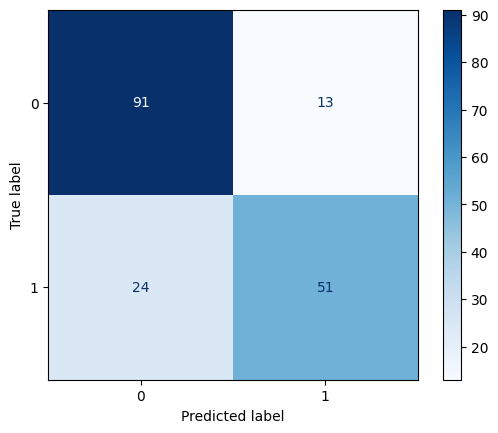

In [160]:
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test, cmap="Blues")

Macierz pomyłek dla drzewa decyzyjnego

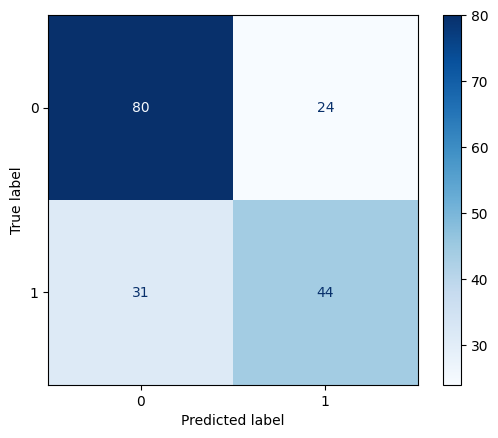

In [161]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues")

Macierz pomyłek dla KNN

Ustawienie maksymalnej głębokości drzewa na 10 i splitter na 'random' nie spowodowało pogorszenia, podobnie dla KNN ustawienie n_neighbors na 10 i wagi na 'distance' nie spowodowało dużego pogorszenia precykcji.
